In [1]:
import scanpy as sc
import gseapy as gp
import matplotlib.pyplot as plt
import gseapy as gp
import anndata as ad
import decoupler
from pathlib import Path

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
split = 6

In [3]:
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_ood_with_predictions_{split}.h5ad")
#adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/combosciplex/adata_test_with_predictions_{split}.h5ad")

In [4]:
adata_pred_ood.X = adata_pred_ood.layers["X_recon_pred"]
#adata_pred_test.X = adata_pred_test.layers["X_recon_pred"]

In [5]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train_{split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test_{split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"

In [6]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [7]:
import numpy as np
adata_pred_ood.X[adata_pred_ood.X<0] = 0

In [8]:
adata_pred_ood = adata_pred_ood[adata_pred_ood.obs["condition"]!="control"]

In [9]:
adata_pred_ood.var_names = adata_ood.var_names
#adata_pred_test.var_names = adata_test.var_names

In [10]:
adata_pred_ood.obs["condition"] = adata_pred_ood.obs.apply(lambda x: x["condition"] + "_pred", axis=1)

In [11]:
adata_full = ad.concat((adata_train, adata_ood, adata_pred_ood))

In [12]:
if not Path("c2.cp.reactome.v7.5.1.symbols.gmt").is_file():
    !wget -O 'c2.cp.reactome.v7.5.1.symbols.gmt' https://figshare.com/ndownloader/files/35233771

In [13]:
import pandas as pd
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )



In [14]:
reactome = gmt_to_decoupler("c2.cp.reactome.v7.5.1.symbols.gmt")

In [15]:
# Retrieving via python
msigdb = decoupler.get_resource("MSigDB")

# Get reactome pathways
reactome = msigdb.query("collection == 'reactome_pathways'")
# Filter duplicates
reactome = reactome[~reactome.duplicated(("geneset", "genesymbol"))]


  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 466, in _make_request
    self._validate_conn(conn)
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connectionpool.py", line 1095, in _validate_conn
    conn.connect()
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 652, in connect
    sock_and_verified = _ssl_wrap_socket_and_match_hostname(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/connection.py", line 805, in _ssl_wrap_socket_and_match_hostname
    ssl_sock = ssl_wrap_socket(
               ^^^^^^^^^^^^^^^^
  File "/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/urllib3/util/ssl_.py", line 465, in ssl_wrap_socket
    ssl_sock = _ssl_wrap_socket_impl(sock, context, tls_in_tls, server_hostnam

In [30]:
sc.tl.rank_genes_groups(adata_full, "condition", method="logreg", key_added="t-test", reference="control")

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


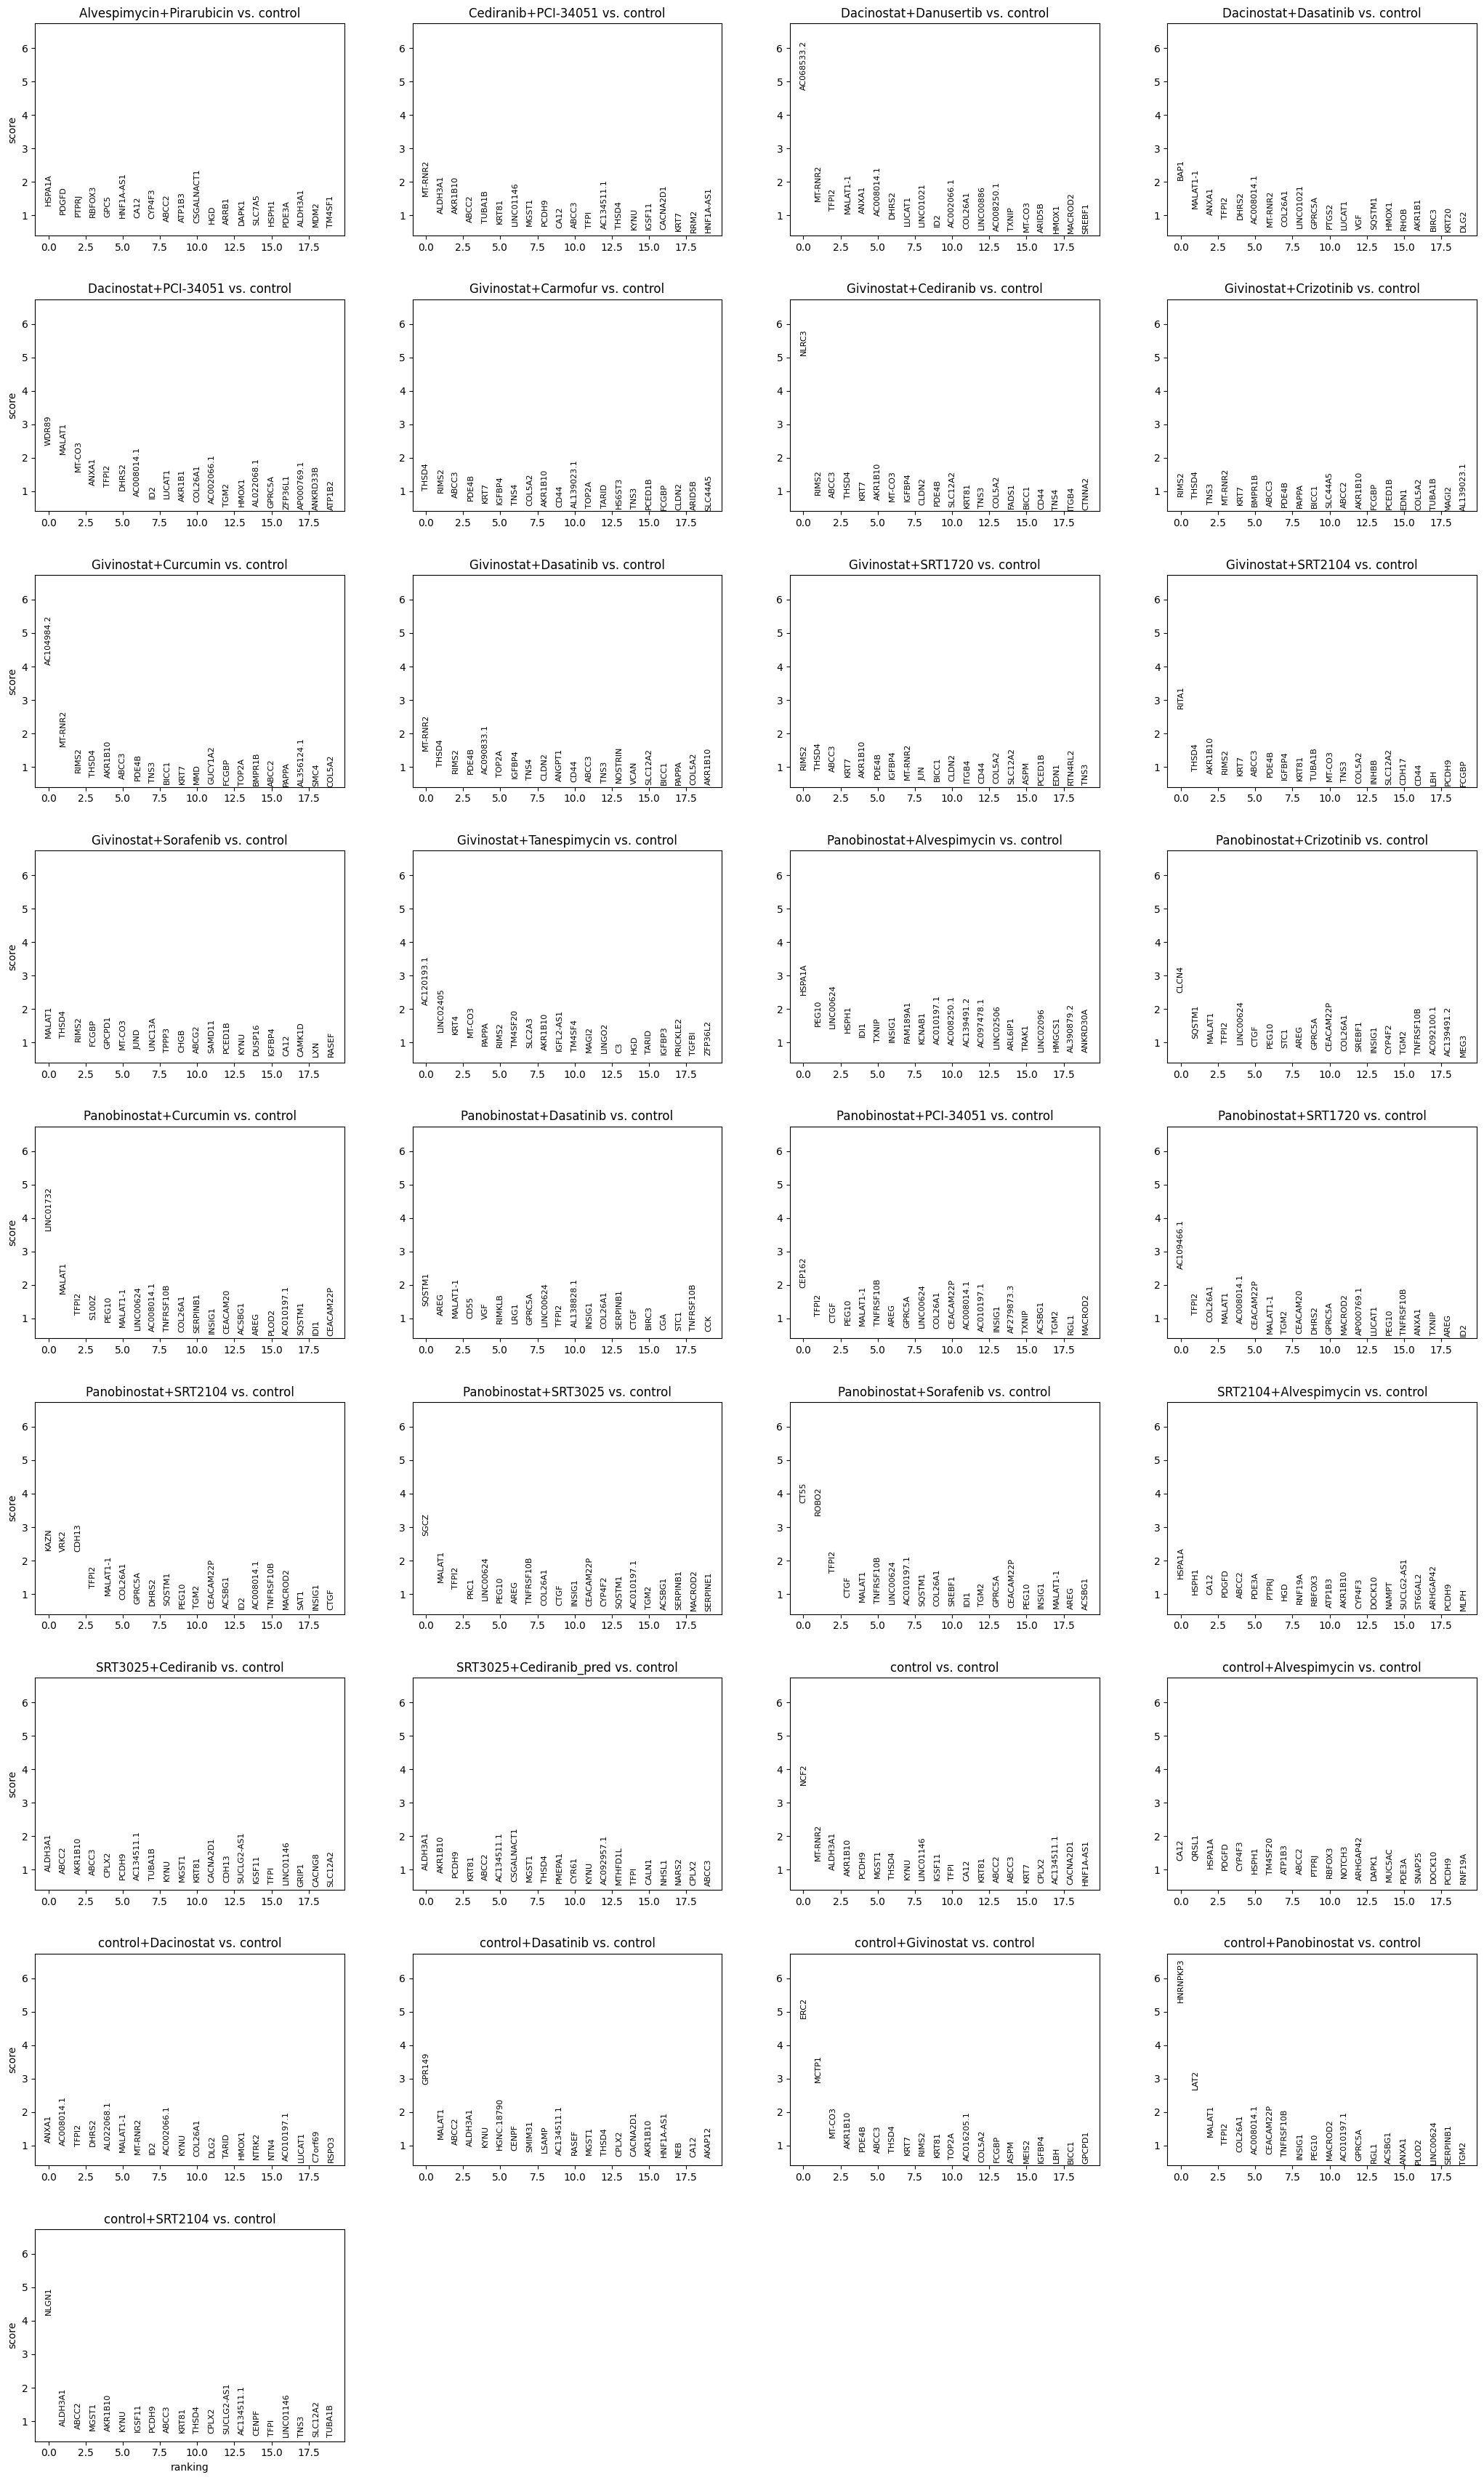

In [31]:
sc.pl.rank_genes_groups(adata_full, key="t-test")

In [32]:
import numpy as np
dict_t_stats = {}

for condition in adata_full.obs["condition"].cat.categories:
    if condition=="control":
        continue
    t_stats = (
        # Get dataframe of DE results for condition vs. rest
        sc.get.rank_genes_groups_df(adata_full, group=condition,  key="t-test")
        .set_index("names")
        # Sort by absolute score
        .sort_values("scores", key=np.abs, ascending=False)
        # Format for decoupler
        [["scores"]]
    )
    dict_t_stats[condition] = t_stats

In [33]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

/tmp/ipykernel_3749305/1613302725.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  geneset_size = reactome.groupby("geneset").size()


In [34]:
dict_gsea_results = {}

for condition, t_stats in dict_t_stats.items():
    scores, norm, pvals = decoupler.run_gsea(
        t_stats.T,
        reactome[reactome["geneset"].isin(gsea_genesets)],
        source="geneset",
        target="genesymbol",
    )
    gsea_results = (
        pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
        .droplevel(level=1, axis=1)
        .sort_values("pval")
    )
    dict_gsea_results[condition] = gsea_results



In [35]:
dict_gsea_results.keys()

dict_keys(['Alvespimycin+Pirarubicin', 'Cediranib+PCI-34051', 'Dacinostat+Danusertib', 'Dacinostat+Dasatinib', 'Dacinostat+PCI-34051', 'Givinostat+Carmofur', 'Givinostat+Cediranib', 'Givinostat+Crizotinib', 'Givinostat+Curcumin', 'Givinostat+Dasatinib', 'Givinostat+SRT1720', 'Givinostat+SRT2104', 'Givinostat+Sorafenib', 'Givinostat+Tanespimycin', 'Panobinostat+Alvespimycin', 'Panobinostat+Crizotinib', 'Panobinostat+Curcumin', 'Panobinostat+Dasatinib', 'Panobinostat+PCI-34051', 'Panobinostat+SRT1720', 'Panobinostat+SRT2104', 'Panobinostat+SRT3025', 'Panobinostat+Sorafenib', 'SRT2104+Alvespimycin', 'SRT3025+Cediranib', 'SRT3025+Cediranib_pred', 'control+Alvespimycin', 'control+Dacinostat', 'control+Dasatinib', 'control+Givinostat', 'control+Panobinostat', 'control+SRT2104'])

In [36]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_NR1H2_AND_NR1H3_MEDIATED_SIGNALING,-0.946950,-1.421659,0.007968
REACTOME_G_ALPHA_S_SIGNALLING_EVENTS,0.840588,1.501577,0.020202
REACTOME_BIOLOGICAL_OXIDATIONS,0.790748,1.478798,0.020513
REACTOME_G_ALPHA_Q_SIGNALLING_EVENTS,-0.792696,-1.467680,0.024554
REACTOME_BINDING_AND_UPTAKE_OF_LIGANDS_BY_SCAVENGER_RECEPTORS,0.897322,1.376021,0.041833
...,...,...,...
REACTOME_RECEPTOR_TYPE_TYROSINE_PROTEIN_PHOSPHATASES,0.358314,0.513650,0.957447
REACTOME_NEUREXINS_AND_NEUROLIGINS,-0.326975,-0.561804,0.958848
REACTOME_REPRODUCTION,-0.350158,-0.543566,0.965377


In [37]:
[el for el in dict_gsea_results['Alvespimycin+Pirarubicin'].index if "TP53" in el]

['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY',
 'REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']

In [38]:
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # 'Alvespimycin+Pirarubicin'
'REACTOME_REGULATION_OF_TP53_ACTIVITY' # maybe even more interesting, as it's for 'Givinostat+Tanespimycin' and 'Alvespimycin+Pirarubicin'
'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53' # affects many conditions, a bit random

'REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53'

In [39]:
dict_gsea_results['Alvespimycin+Pirarubicin']

,score,norm,pval
source,,,
REACTOME_NR1H2_AND_NR1H3_MEDIATED_SIGNALING,-0.946950,-1.421659,0.007968
REACTOME_G_ALPHA_S_SIGNALLING_EVENTS,0.840588,1.501577,0.020202
REACTOME_BIOLOGICAL_OXIDATIONS,0.790748,1.478798,0.020513
REACTOME_G_ALPHA_Q_SIGNALLING_EVENTS,-0.792696,-1.467680,0.024554
REACTOME_BINDING_AND_UPTAKE_OF_LIGANDS_BY_SCAVENGER_RECEPTORS,0.897322,1.376021,0.041833
...,...,...,...
REACTOME_RECEPTOR_TYPE_TYROSINE_PROTEIN_PHOSPHATASES,0.358314,0.513650,0.957447
REACTOME_NEUREXINS_AND_NEUROLIGINS,-0.326975,-0.561804,0.958848
REACTOME_REPRODUCTION,-0.350158,-0.543566,0.965377


In [40]:
res = {}
res_score = {}
res_norm = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["pval"]
    res_score[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["score"]
    res_norm[cond] = df.loc['REACTOME_REGULATION_OF_TP53_ACTIVITY_THROUGH_PHOSPHORYLATION']["norm"]

In [41]:
res

{'Alvespimycin+Pirarubicin': 0.5458015,
 'Cediranib+PCI-34051': 0.026476579,
 'Dacinostat+Danusertib': 0.6940559,
 'Dacinostat+Dasatinib': 0.10583942,
 'Dacinostat+PCI-34051': 0.8502879,
 'Givinostat+Carmofur': 0.1625,
 'Givinostat+Cediranib': 0.06275304,
 'Givinostat+Crizotinib': 0.27919707,
 'Givinostat+Curcumin': 0.06614786,
 'Givinostat+Dasatinib': 0.44419643,
 'Givinostat+SRT1720': 0.35115865,
 'Givinostat+SRT2104': 0.46588695,
 'Givinostat+Sorafenib': 0.3288719,
 'Givinostat+Tanespimycin': 0.75062346,
 'Panobinostat+Alvespimycin': 0.17938931,
 'Panobinostat+Crizotinib': 0.024896266,
 'Panobinostat+Curcumin': 0.25044093,
 'Panobinostat+Dasatinib': 0.033542976,
 'Panobinostat+PCI-34051': 0.15799615,
 'Panobinostat+SRT1720': 0.0620985,
 'Panobinostat+SRT2104': 0.016359918,
 'Panobinostat+SRT3025': 0.082311735,
 'Panobinostat+Sorafenib': 0.044176705,
 'SRT2104+Alvespimycin': 0.25,
 'SRT3025+Cediranib': 0.02283105,
 'SRT3025+Cediranib_pred': 0.31282052,
 'control+Alvespimycin': 0.6867

In [42]:
res_score


{'Alvespimycin+Pirarubicin': 0.62596774,
 'Cediranib+PCI-34051': 0.8291886,
 'Dacinostat+Danusertib': -0.4734765,
 'Dacinostat+Dasatinib': -0.7364625,
 'Dacinostat+PCI-34051': -0.36532137,
 'Givinostat+Carmofur': 0.68601036,
 'Givinostat+Cediranib': 0.75539976,
 'Givinostat+Crizotinib': 0.6152623,
 'Givinostat+Curcumin': 0.7610609,
 'Givinostat+Dasatinib': 0.53725076,
 'Givinostat+SRT1720': 0.6062327,
 'Givinostat+SRT2104': 0.54880637,
 'Givinostat+Sorafenib': -0.6437816,
 'Givinostat+Tanespimycin': -0.45475194,
 'Panobinostat+Alvespimycin': -0.7551916,
 'Panobinostat+Crizotinib': -0.8202119,
 'Panobinostat+Curcumin': -0.6387308,
 'Panobinostat+Dasatinib': -0.8073578,
 'Panobinostat+PCI-34051': -0.6910877,
 'Panobinostat+SRT1720': -0.75951445,
 'Panobinostat+SRT2104': -0.82129776,
 'Panobinostat+SRT3025': -0.7449762,
 'Panobinostat+Sorafenib': -0.77398294,
 'SRT2104+Alvespimycin': 0.7240003,
 'SRT3025+Cediranib': 0.8216977,
 'SRT3025+Cediranib_pred': 0.7202147,
 'control+Alvespimycin':

In [29]:
res_norm

{'Alvespimycin+Pirarubicin': -1.4823033,
 'Cediranib+PCI-34051': 1.2570282,
 'Dacinostat+Danusertib': -1.8443142,
 'Dacinostat+Dasatinib': -1.7829567,
 'Dacinostat+PCI-34051': -1.8042514,
 'Givinostat+Carmofur': -2.127059,
 'Givinostat+Cediranib': -2.0707626,
 'Givinostat+Crizotinib': -1.9714901,
 'Givinostat+Curcumin': -1.920187,
 'Givinostat+Dasatinib': -2.0360873,
 'Givinostat+SRT1720': -2.1711643,
 'Givinostat+SRT2104': -2.1256945,
 'Givinostat+Sorafenib': -1.8584995,
 'Givinostat+Tanespimycin': -1.8966137,
 'Panobinostat+Alvespimycin': -1.7121068,
 'Panobinostat+Crizotinib': -1.6746925,
 'Panobinostat+Curcumin': -1.6983522,
 'Panobinostat+Dasatinib': -1.6450385,
 'Panobinostat+PCI-34051': -1.6807288,
 'Panobinostat+SRT1720': -1.7468319,
 'Panobinostat+SRT2104': -1.751734,
 'Panobinostat+SRT3025': -1.6857518,
 'Panobinostat+Sorafenib': -1.6714375,
 'SRT2104+Alvespimycin': -1.1871709,
 'SRT3025+Cediranib': 0.87136763,
 'SRT3025+Cediranib_pred': -1.1147012,
 'control+Alvespimycin': -

In [58]:
pd.DataFrame(res_score, index=[0]).to_csv("gse_score_4.csv")

In [83]:
gsea_results = dict_gsea_results['Alvespimycin+Pirarubicin']

In [29]:
import seaborn as sns
dict_gsea_results['Alvespimycin+Pirarubicin']["source"] = dict_gsea_results['Alvespimycin+Pirarubicin'].index
sns.barplot(data=dict_gsea_results['Alvespimycin+Pirarubicin'].head(10), x="source", y="score")

<Axes: xlabel='source', ylabel='score'>

Error in callback <function _draw_all_if_interactive at 0x7f37d53ee200> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f37ce65f380> (for post_execute):


KeyboardInterrupt: 

In [91]:
df_tmp = dict_gsea_results['Alvespimycin+Pirarubicin'].head(10)

In [ ]:
sns.barplot(df_tmp, x="source", y="pval")

<Axes: xlabel='source', ylabel='pval'>

Error in callback <function _draw_all_if_interactive at 0x7f17f2342200> (for post_execute):


KeyboardInterrupt: 

In [41]:
adata_pred_ood.obs["condition"].value_counts()

condition
Panobinostat+Crizotinib    500
Panobinostat+Curcumin      500
Panobinostat+SRT1720       500
Panobinostat+Sorafenib     500
SRT2104+Alvespimycin       500
control+Alvespimycin       500
control+Dacinostat         500
Name: count, dtype: int64

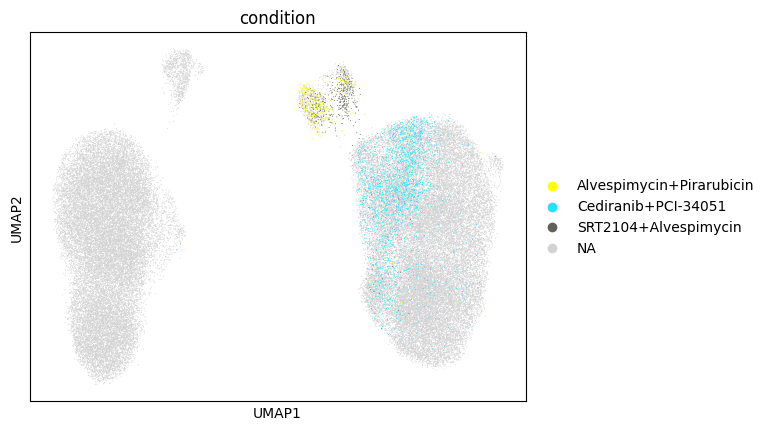

In [43]:
sc.pl.umap(adata_full, color="condition", groups=['Cediranib+PCI-34051', 'SRT2104+Alvespimycin', 'Alvespimycin+Pirarubicin'])

In [48]:
adata_ood.obs["condition"].value_counts()

condition
SRT3025+Cediranib         3016
Givinostat+Dasatinib      2421
control+Dasatinib         2343
Givinostat+SRT1720        2260
Panobinostat+SRT2104      1971
Panobinostat+Dasatinib    1955
Panobinostat+PCI-34051    1814
Name: count, dtype: int64

In [55]:
split = 3
ood_tmp_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood_{split}.h5ad"
adata_ood_tmp = sc.read_h5ad(ood_tmp_path)

In [56]:
adata_ood_tmp.obs["condition"].value_counts()

condition
Panobinostat+Curcumin      2244
Panobinostat+Sorafenib     2013
control+Dacinostat         1869
Panobinostat+SRT1720       1826
Panobinostat+Crizotinib    1641
control+Alvespimycin        758
SRT2104+Alvespimycin        520
control                     500
Name: count, dtype: int64

In [44]:
res = {}
for cond, df in dict_gsea_results.items():
    res[cond] = df.loc['REACTOME_TRANSCRIPTIONAL_REGULATION_BY_TP53']["pval"]

In [45]:
res


{'Alvespimycin+Pirarubicin': 0.0099502485,
 'Cediranib+PCI-34051': 0.013767209,
 'Dacinostat+Danusertib': 0.009049774,
 'Dacinostat+Dasatinib': 0.009124087,
 'Dacinostat+PCI-34051': 0.010958904,
 'Givinostat+Carmofur': 0.004716981,
 'Givinostat+Cediranib': 0.032786883,
 'Givinostat+Crizotinib': 0.0,
 'Givinostat+Curcumin': 0.0,
 'Givinostat+SRT2104': 0.030612245,
 'Givinostat+Sorafenib': 0.0025575447,
 'Givinostat+Tanespimycin': 0.013245033,
 'Panobinostat+Alvespimycin': 0.04694836,
 'Panobinostat+Crizotinib': 0.075987846,
 'Panobinostat+Curcumin': 0.015189873,
 'Panobinostat+SRT1720': 0.022038568,
 'Panobinostat+SRT3025': 0.05929919,
 'Panobinostat+Sorafenib': 0.03583062,
 'SRT2104+Alvespimycin': 0.17307693}

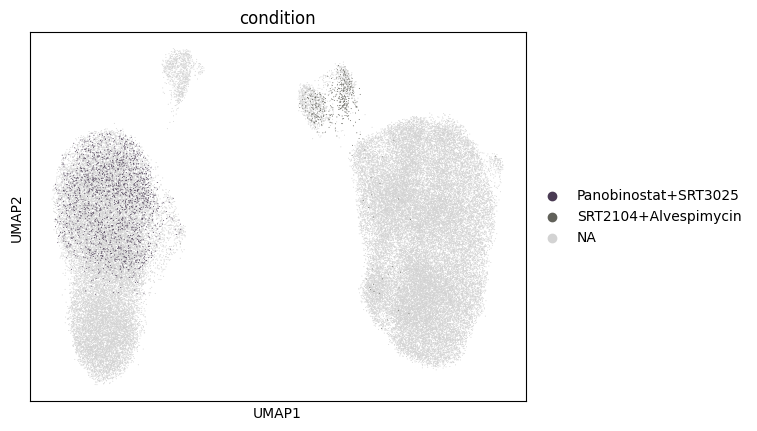

In [47]:
sc.pl.umap(adata_full, color="condition", groups=['SRT2104+Alvespimycin', 'Panobinostat+SRT3025'])

In [157]:
[el for el in adata_train.var_names if "TP" in el] 

['ATP1B3',
 'TP63',
 'TPX2',
 'ATP1B2',
 'PTPRJ',
 'PTPRD',
 'PITPNC1',
 'TPPP3',
 'CTPS1',
 'MCTP1',
 'TPRX1',
 'ATP13A5',
 'GRTP1-AS1',
 'ATP6V1G2-DDX39B']

In [151]:
adata_ood.obs["condition"].value_counts()

condition
Dacinostat+PCI-34051         3298
Givinostat+Cediranib         2783
Givinostat+Curcumin          2736
Panobinostat+SRT3025         1889
control+Panobinostat         1578
Dacinostat+Dasatinib         1231
Panobinostat+Alvespimycin     996
Name: count, dtype: int64

In [111]:
[el for el in gsea_results.index.values if "EGFR" in el]

[]

In [102]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/seaborn/_core/plot.py:1043: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.savefig(buffer, dpi=dpi, format="png", bbox_inches="tight")


KeyboardInterrupt: 